<a href="https://colab.research.google.com/github/rsudiplive/Implementing-Decision-Tree-from-scratch/blob/main/Predicting_weather_Decision_Tree_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What is a Decision Tree?

<b>Decision tree </b> is a type of <b>supervised learning algorithm</b> that is mostly used in classification problems. It works for both categorical and continuous input and output variables. 

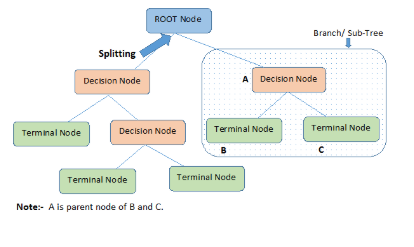



<b>Root Node:</b> It represents entire population or sample and this further gets divided into two sets.

<b>Splitting:</b> It is a process of dividing a node into two sub-nodes.

<b>Decision Node:</b> When a sub-node splits into further sub-nodes, then it is called decision node.

<b> Leaf/ Terminal Node:</b> Nodes do not split is called leaf or terminal node.

<b> Pruning:</b> When we remove sub-nodes of a decision node, this process is called pruning. You can say opposite process of splitting.

<b>Branch / Sub-Tree:</b> A sub section of entire tree is called branch or sub-tree.

<b>Parent and Child Node:</b> A node, which is divided into sub-nodes is called parent node of sub-nodes where as sub-nodes are the child of parent node.


How to split? <br>

Here we'll be using the concept of **GINI impurity** to calculate the impurities of the nodes in the decision tree and come up with the **best split** going forward!

We'll be constructing a Decision tree involving weather classification and will be predicting if the weather is bad/not based on decision nodes like Lightning, temperature, rain and cloudy.

This notebook focuses on writing modularized code with python using classes, functions and methods to come up with the good/bad weather.

In [1]:
import pandas as pd

In [2]:
class WeatherItem:
    def __init__(self, rain, lightning, cloudy, temperature, good_weather_ind = None):
        self.rain = rain
        self.lightning = lightning
        self.cloudy = cloudy
        self.temperature = temperature
        self.good_weather_ind = good_weather_ind


all_samples = [(WeatherItem(row[0], row[1], row[2], row[3], row[4])) for index, row in
               pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dat/good_weather_classification.csv").iterrows()]

In [5]:
#defining the feature class
class Feature:
    def __init__(self, feature_name, value_extractor):
        self.feature_name = feature_name
        self.value_extractor = value_extractor

    def __str__(self):
        return self.feature_name

In [14]:
features = [Feature("Rain", lambda wi: wi.rain),
            Feature("Lightning", lambda wi: wi.lightning),
            Feature("Cloudy", lambda wi: wi.cloudy),
            Feature("Temperature", lambda wi: wi.temperature)]

In [6]:
# get impurity for provided samples
def gini_impurity(samples):
    good_weather_item_ct = sum(1 for weather_item in samples if weather_item.good_weather_ind == 1)
    bad_weather_item_ct = sum(1 for weather_item in samples if weather_item.good_weather_ind == 0)
    sample_ct = len(samples)

    return 1.0 - (good_weather_item_ct / sample_ct) ** 2 - (bad_weather_item_ct / sample_ct) ** 2

In [7]:
# get weighted impurity for entire node
def gini_impurity_for_split(feature, split_value, samples):
    feature_positive_items = [weather_item for weather_item in samples if feature.value_extractor(weather_item) >= split_value]
    feature_negative_items = [weather_item for weather_item in samples if feature.value_extractor(weather_item) < split_value]

    return (gini_impurity(feature_positive_items) * (len(feature_positive_items) / len(samples)) ) + (
            gini_impurity(feature_negative_items) * (len(feature_negative_items) / len(samples)) )


In [8]:
def split_continuous_variable(feature, samples):
    feature_values = list(set(feature.value_extractor(weather_item) for weather_item in samples))
    feature_values.sort()

    feature_values2 = feature_values.copy()
    feature_values2.pop(0)

    best_impurity = 1.0
    best_split = None
    zipped_values = zip(feature_values, feature_values2)

    for pair in zipped_values:
        split_value = (pair[0] + pair[1]) / 2
        impurity = gini_impurity_for_split(feature, split_value, samples)
        if impurity < best_impurity:
            best_impurity = impurity
            best_split = split_value

    return best_split

In [12]:
class TreeLeaf:

    def __init__(self, feature, split_value, samples):
        self.feature = feature
        self.split_value = split_value
        self.samples = samples
        self.feature_positive_items = [e for e in samples if feature.value_extractor(e) >= split_value]
        self.feature_negative_items = [e for e in samples if feature.value_extractor(e) < split_value]
        self.weighted_gini_impurity = gini_impurity_for_split(feature, split_value, samples)

        self.feature_positive_leaf = build_leaf(self.feature_positive_items, self)
        self.feature_negative_leaf = build_leaf(self.feature_negative_items, self)

    def predict(self, weather_item):
        print(self)
        feature_value = self.feature.value_extractor(weather_item)
        if feature_value >= self.split_value:
            if self.feature_positive_leaf is None:
                return sum(1 for e in self.feature_positive_items if e.good_weather_ind == 1) / len(self.feature_positive_items)
            else:
                return self.feature_positive_leaf.predict(weather_item)
        else:
            if self.feature_negative_leaf is None:
                return sum(1 for e in self.feature_negative_items if e.good_weather_ind == 1) / len(self.feature_negative_items)
            else:
                return self.feature_negative_leaf.predict(weather_item)

    def __str__(self):
        return "{0} split on {1}, {3}|{2}, Impurity: {4}|{5}, Weighted Impurity: {6}".format(self.feature, self.split_value,
                                                                 len(self.feature_positive_items),
                                                                 len(self.feature_negative_items),
                                                                 gini_impurity(self.feature_positive_items),
                                                                 gini_impurity(self.feature_negative_items),
                                                                 self.weighted_gini_impurity)


In [16]:
def build_leaf(weather_items, previous_leaf):
    best_impurity = 1.0
    best_split = None
    best_feature = None

    # Find feature with lowest impurity
    for feature in features:
        split_value = split_continuous_variable(feature, weather_items)

        # If value cannot be split, skip
        if split_value is None:
            continue

        impurity = gini_impurity_for_split(feature, split_value, weather_items)

        # Keep track of best feature with lowest impurity
        if best_impurity > impurity:
            best_impurity = impurity
            best_feature = feature
            best_split = split_value

    # The gini impurity of the samples must be improved with the next best split, otherwise the branch ends here
    if previous_leaf is None or gini_impurity(weather_items) > best_impurity:
        return TreeLeaf(best_feature, best_split, weather_items)
    else:
        return None


tree = build_leaf(all_samples, None)

def recurse_and_print_tree(leaf, depth=0):
    if leaf is not None:
        print(("\t" * depth) + "({0}) ".format(depth) + str(leaf))
        recurse_and_print_tree(leaf.feature_negative_leaf, depth + 1)
        recurse_and_print_tree(leaf.feature_positive_leaf, depth + 1)


recurse_and_print_tree(tree)

(0) Rain split on 0.5, 34|16, Impurity: 0.0|0.4844290657439447, Weighted Impurity: 0.3294117647058824
	(1) Temperature split on 78.5, 23|11, Impurity: 0.0|0.4763705103969754, Weighted Impurity: 0.32225063938618925
		(2) Lightning split on 0.5, 15|8, Impurity: 0.0|0.12444444444444439, Weighted Impurity: 0.08115942028985504
			(3) Temperature split on 76.5, 12|3, Impurity: 0.4444444444444445|0.0, Weighted Impurity: 0.0888888888888889
				(4) Cloudy split on 0.5, 2|1, Impurity: 0.0|0.0, Weighted Impurity: 0.0


In [18]:
# Let's interact and test with new data
def predict_weather_will_be_good(rain, lightning, cloudy, temperature):
    rate_of_good_weather = tree.predict(WeatherItem(rain, lightning, cloudy, temperature))
    if rate_of_good_weather >= .5:
        return "Weather is good, {0}% records in node are good\r\n".format(round(rate_of_good_weather * 100.0, 2))
    else:
        return "Weather is bad, {0}%  records in node  are bad\r\n".format(round(rate_of_good_weather * 100.0, 2))


while True:
    n = input("\r\nPredict if weather is good {rain},{lightning},{cloudy},{temperature}: ")
    (rain, lightning, cloudy, temperature) = n.split(",")
    print(predict_weather_will_be_good(int(rain), int(lightning), int(cloudy), int(temperature)))

    break


Predict if weather is good {rain},{lightning},{cloudy},{temperature}: 0,1,0,45
Rain split on 0.5, 34|16, Impurity: 0.0|0.4844290657439447, Weighted Impurity: 0.3294117647058824
Temperature split on 78.5, 23|11, Impurity: 0.0|0.4763705103969754, Weighted Impurity: 0.32225063938618925
Lightning split on 0.5, 15|8, Impurity: 0.0|0.12444444444444439, Weighted Impurity: 0.08115942028985504
Weather is bad, 0.0%  records in node  are bad

